# MNIST Classification with an MLP Hugging Face Model

This notebook shows you how to run a pretrained model hosted on Hugging Face. https://huggingface.co/dacorvo/mnist-mlp

## 🛠️ Supported Hardware

This notebook can run in a CPU or in a GPU.

✅ AMD Instinct™ Accelerators  
✅ AMD Radeon™ RX/PRO Graphics Cards  
✅ AMD EPYC™ Processors  
✅ AMD Ryzen™ (AI) Processors  

Suggested hardware: **AI PC powered by AMD Ryzen™ AI Processors**

## ⚡ Recommended Software Environment

::::{tab-set}

:::{tab-item} Linux
- [Install Docker container](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::

:::{tab-item} Windows
- [Install Direct-ML](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu-windows.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::
::::

## 🎯 Goals

- Show you how to download a model from HuggingFace
- Run MNIST on an AMD platform
- Explore the MNIST dataset and run inference of one of the test examples

## 🚀 Run MNIST on an AMD Platform

Import packages, in particular [Hugging Face `transformers`](https://huggingface.co/docs/transformers/en/index) that helps downloading the model from the Hugging Face repository.

In [1]:
import torch
from transformers import AutoModel
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

Download the model from Hugging Face using `transformers.AutoModel` by specifying address. See more information on how to download models [here](https://huggingface.co/docs/hub/en/models-downloading).

In [2]:
model = AutoModel.from_pretrained("dacorvo/mnist-mlp", trust_remote_code=True)

Display the model layers, as you can see, this is a very simple model with 3 layers.

| Layer name | Input Features | Output Features |
|------------|----------------|-----------------|
| Input      |     784        |      256        |
| Middle     |     256        |      256        |
| Output     |     256        |       10        | 

In [3]:
print(model)

MLP(
  (input_layer): Linear(in_features=784, out_features=256, bias=True)
  (mid_layer): Linear(in_features=256, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)


Download MNIST dataset and apply a normalization transformation as well as flattening the dimensions. As you can see, we do not download the training data.

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: torch.flatten(x)),
])

test_set = datasets.MNIST('datasets/', train=False, download=True, transform=transform)

Get a random number to index a sample from the test set

In [5]:
index = int(torch.randint(low=0, high=test_set.test_data.shape[0], size=(1,)))
data, label = test_set[index]
print(f'Random {index=} with {label=}')

Random index=5760 with label=3


/opt/conda/envs/py_3.12/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Show the hand-written digit that we have randomly selected

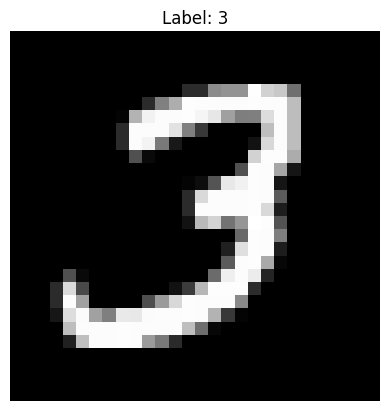

In [6]:
fig = plt.figure
plt.imshow(data.reshape(28,28), cmap='gray')
plt.axis('off')
plt.title(f'Label: {int(label)}')
plt.show()

Now, we can run an inference with the sample data on the model.

```{note}
We run the inference inside of the `torch.no_grad()` context in order not to track gradients. This saves memory and computation.
```

In [7]:
with torch.no_grad():
    output = model(data)
output

tensor([3.6064e-12, 5.5341e-13, 1.1835e-07, 1.0000e+00, 1.8841e-17, 7.7729e-09,
        4.6632e-18, 2.2053e-12, 6.5412e-11, 8.4408e-15])

Because the model has ten output neurons, we are going to use `torch.argmax` to get the index of the neuron with the highest probability.

In [8]:
predicted = torch.argmax(output)
predicted

tensor(3)

We can now check if the class we got after inference is the correct one. 

In [9]:
print(f'Is the prediction correct? {predicted == label}')

Is the prediction correct? True


Compute the accuracy of the downloaded model by checking the complete test set.
We first create a `DataLoader` object that we will use to iterate over the test images. Using this object we loop over the images and labels, we use images to run the batched inference, then using the output we compute the predicted class and compare them with the actual class to compute the total number of correct predictions. After this, we can print the test accuracy.

In [10]:
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
correct_classifications = 0
for images, labels in test_loader:
    with torch.no_grad():
        output = model(images)
    correct_classifications += torch.sum(torch.argmax(output, dim=1) == labels).item()

print(f'Test accuracy: {100*correct_classifications/len(test_set): .2f}%')

Test accuracy:  96.57%


----------
Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.

SPDX-License-Identifier: MIT